## Predicting Medical Costs with Linear Regression

In this project, we work with the **Medical Cost Dataset** from Kaggle, which contains information about individual medical insurance charges along with demographic and personal attributes such as age, sex, BMI, smoking status, and region.

### Project Objective

Our goal is to build a regression model that predicts the **total medical cost** for a patient based on their characteristics. Since the target variable is continuous and positive, linear regression is a suitable modeling choice.

Accurately predicting medical costs can help healthcare providers:
- Estimate future revenue.
- Allocate resources more efficiently.
- Plan treatments and procedures based on expected patient needs.

We will explore the dataset, prepare the features, and evaluate different regression models to find the best-performing approach.

In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
insurance = pd.read_csv("insurance.csv")

In [3]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [11]:
print(insurance.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


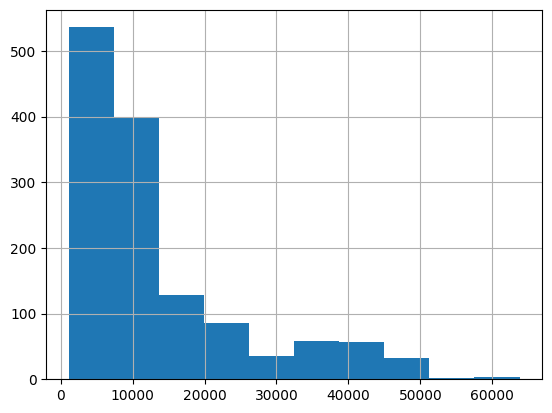

In [16]:
insurance["charges"].hist()
plt.show()

### Log Transformation of the Target Variable

The distribution of the target variable `charges` is **right-skewed**, which can negatively impact the performance of linear regression models by violating the assumption of normally distributed residuals.

To address this, we apply a **log transformation** to `charges`, which helps:
- Reduce skewness.
- Stabilize variance.
- Improve linear relationship with predictors.

This transformation makes the data more suitable for modeling with linear regression.

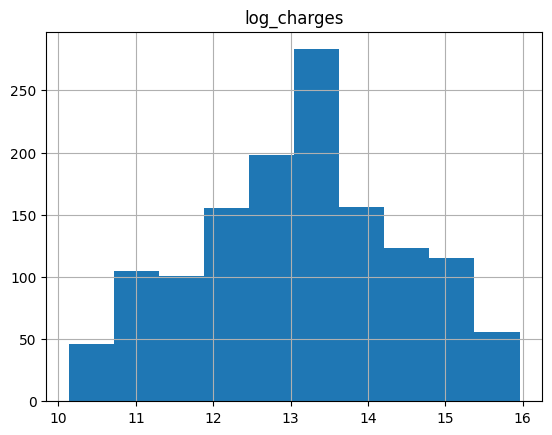

In [17]:
insurance["log_charges"] = np.log2(insurance["charges"])

insurance.hist("log_charges")
plt.show()

In [20]:
insurance_corr = insurance.corr(numeric_only=True)
insurance_corr

,age,bmi,children,charges,log_charges
age,1.000000,0.109272,0.042469,0.299008,0.527834
bmi,0.109272,1.000000,0.012759,0.198341,0.132669
children,0.042469,0.012759,1.000000,0.067998,0.161336
charges,0.299008,0.198341,0.067998,1.000000,0.892964
log_charges,0.527834,0.132669,0.161336,0.892964,1.000000


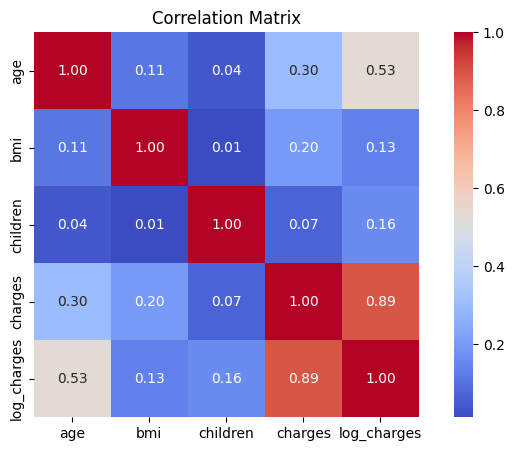

In [19]:
plt.figure(figsize=(9, 5))
sns.heatmap(insurance_corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()

### Correlation Analysis

We examined the correlation between numerical features and the target variable `charges` (as well as its log-transformed version `log_charges`).

#### Key Observations:
- `age` has a **moderate positive correlation** with `log_charges` (0.53), suggesting that older individuals tend to incur higher medical costs.
- `bmi` shows a **weak correlation** with `log_charges` (0.13), indicating a slight upward trend in charges with higher BMI.
- `children` has a **weak positive correlation** (0.16) with `log_charges`, suggesting a minimal influence.
- The original `charges` variable had a lower correlation with `age` (0.30), which **improved to 0.53** after the log transformation—supporting the decision to use the transformed target.

Overall, the log transformation not only improved the distribution of the target but also strengthened its linear relationship with key predictors, especially `age`.

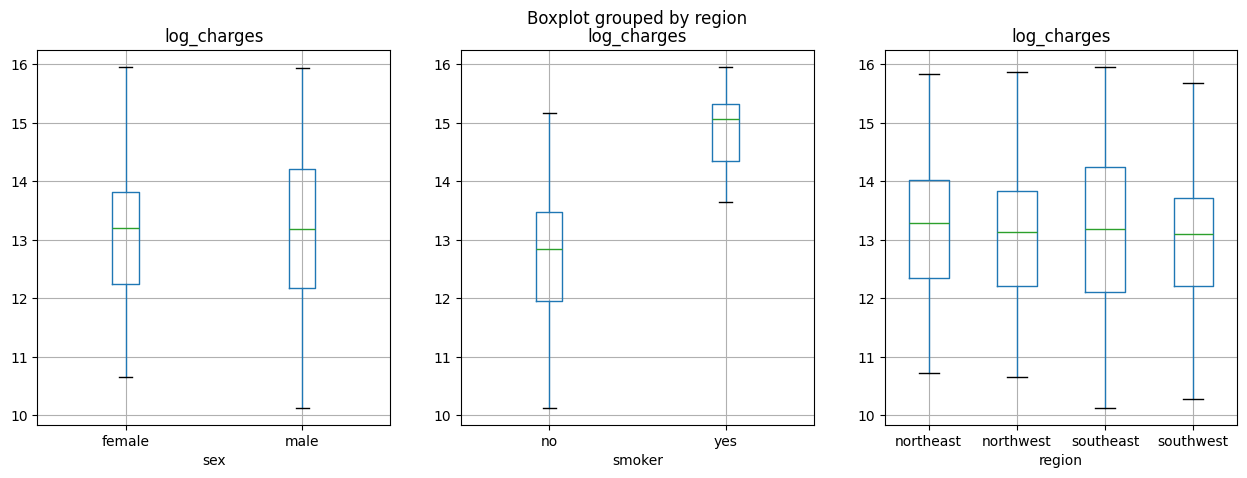

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

insurance.boxplot(column=["log_charges"], by="sex", ax=axs[0])
insurance.boxplot(column=["log_charges"], by="smoker", ax=axs[1])
insurance.boxplot(column=["log_charges"], by="region", ax=axs[2])

plt.show()

### Feature Selection

Based on exploratory analysis and visualizations, we selected the following features for our regression model:

- `age`: Moderately correlated with `log_charges` (0.53). Medical costs tend to increase with age.
- `bmi`: Weakly correlated with `log_charges`, but still relevant due to its connection to health outcomes.
- `smoker`: The **box plot shows a dramatic difference** in charges between smokers and non-smokers. 

### Splitting the Data

Before training the model, we divide the dataset into two parts:

- **Training Set**: Used to fit the regression model and estimate the coefficients.
- **Test Set**: Used to evaluate how well the model performs on unseen data.

This separation is critical to ensure that the model's evaluation reflects its **ability to generalize**, rather than its performance on data it has already seen.

By keeping the test set untouched during training, we can obtain an unbiased estimate of the model’s prediction error on new data.

In [25]:
insurance = pd.get_dummies(insurance, columns=["smoker"], drop_first=True)

X = insurance[["age", "bmi", "smoker_yes"]]  
y = insurance["log_charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Building the Linear Regression Model

With the data split into training and test sets, we now fit a **linear regression model** using the selected features: `age`, `bmi`, and `smoker`.

After training the model on the training set, we examine:
- **Regression coefficients**: These indicate how each feature impacts the predicted medical cost (on a log scale).
- **Coefficient of determination ($R^2$)**: Measures how well the model explains the variability in the target variable.
- **Training set performance**: Helps us understand how well the model fits the data it was trained on.

In [31]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)
train_predictions = lrm.predict(X_train)

train_mse = mean_squared_error(y_train, train_predictions)
print("mean squared error", train_mse)

train_r2 = lrm.score(X_train, y_train)
print("coefficient of determination", train_r2)

print(pd.Series(lrm.coef_, index=X_train.columns))

mean squared error 0.45435840987226683
coefficient of determination 0.737066139753993
age           0.050253
bmi           0.016088
smoker_yes    2.234142
dtype: float64


### Model Evaluation on Training Set

- **MSE:** 0.454  
- **R²:** 0.737  

The model explains ~74% of the variance in `log_charges`, indicating a good fit on the training data.

### Model Coefficients

| Feature       | Coefficient | Interpretation |
|---------------|-------------|----------------|
| `age`         | 0.050       | ~5% increase in charges per year of age |
| `bmi`         | 0.016       | ~1.6% increase per BMI unit |
| `smoker_yes`  | 2.234       | Smokers have ~9.3× higher charges than non-smokers |

### Notes
- `smoker_yes` has the strongest effect on cost.
- Model fits training data well.
- Test set evaluation is needed to assess generalization.


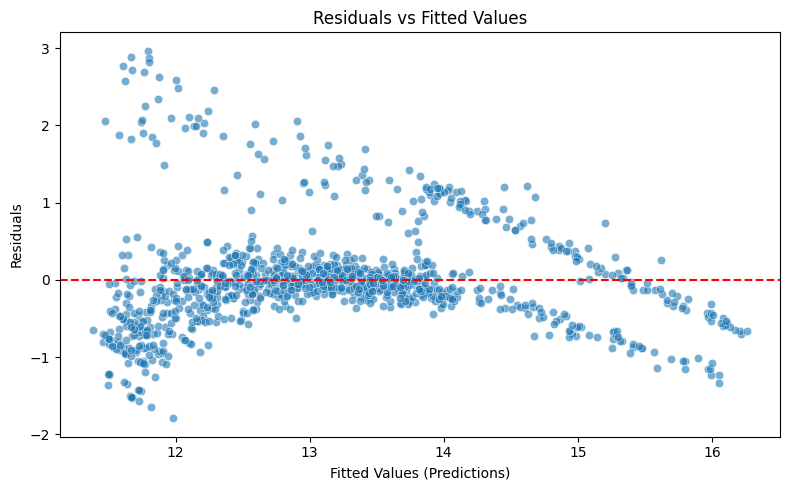

In [33]:
lrm_residuals = y_train - train_predictions

residuals_df = pd.DataFrame({
    "Fitted Values": train_predictions,
    "Residuals": lrm_residuals
})

plt.figure(figsize=(8, 5))
sns.scatterplot(data=residuals_df, x="Fitted Values", y="Residuals", alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values (Predictions)")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

### Residual Analysis

The residuals show a downward trend as predicted values increase, suggesting a violation of linear regression assumptions — specifically, **non-constant variance**.

While this doesn’t make the model unusable, it indicates that a simple linear model may not fully capture the relationship and that a more flexible model might improve performance.

### Interpreting the Model

From a hospital administrator's perspective, the regression coefficients offer **actionable insights**. For example:

- A strong positive coefficient for `smoker` suggests significantly higher costs for smokers, highlighting the need for targeted health interventions.
- The relationship between `age` and cost can inform age-specific resource planning.

These insights can help **reallocate resources** more efficiently across hospitals or departments, especially for facilities serving more vulnerable patient populations.

In [35]:
lrm_intercept = lrm.intercept_
print(lrm_intercept)

10.218903343382255


The intercept represents the predicted value of log_charges when all predictors are zero:

- age = 0
- bmi = 0
- smoker_yes = 0

This is not a meaningful real-world scenario, because:
- A person with age 0 and BMI 0 doesn't exist in your data.
- So the intercept in this context is just a mathematical anchor — it helps position the regression plane, but shouldn’t be interpreted literally.

### Final Model Evaluation

To assess how well the model generalizes, we evaluate its performance on the **test set**, which contains data the model has not seen before.

Unlike training error, the **test error** provides a more realistic estimate of the model's predictive ability on new, unseen data.

We use appropriate metrics (e.g., RMSE or $R^2$) to quantify how accurately the model predicts medical costs. If the test performance is consistent with training results, we can be more confident in the model’s generalizability.

In [36]:
test_predictions = lrm.predict(X_test)

test_mse = mean_squared_error(y_test, test_predictions)
print("mean squared error", train_mse)

test_r2 = lrm.score(X_test, y_test)
print("coefficient of determination", test_r2)

print(pd.Series(lrm.coef_, index=X_test.columns))

mean squared error 0.45435840987226683
coefficient of determination 0.7704945422014753
age           0.050253
bmi           0.016088
smoker_yes    2.234142
dtype: float64


In [37]:
np.exp2(mean_squared_error(y_test, test_predictions))

np.float64(1.346772804590541)

### Drawing Conclusions

The model performed similarly on both the training and test sets, with an MSE of approximately **0.454** on each. This suggests the model **generalizes well** to new data.

However, the residual pattern and modest performance indicate there’s room for improvement. Potential next steps include:
- Adding **interaction terms** (e.g., between `age` and `smoker`)
- Including **nonlinear terms** (e.g., `bmi²`) to better capture complex relationships

These enhancements could help the model better reflect real-world patterns in medical costs.